In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from datetime import datetime, timedelta

# Alerts data preprocessing
The following preprocessing is necessary to perform analysis afterwards

In [ ]:
# Lines added to make dataframes with large number of columns get displayed in their entirety
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
extension = "/content"

In [ ]:
df = pd.read_csv(extension + '/alerts_data.csv', index_col=False)

<ipython-input-380-8c7a770ad2ab>:1: DtypeWarning: Columns (24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(extension + '/alerts_data.csv', index_col=False)


In [ ]:
# converting time-based columns from type string to type timestamp
alerts_timedate_cols = ['alert_creation_timestamp', 'alert_first_triaged', 'alert_triage_due_date', 'alert_bug_due_date', 'alert_bug_updated']
for i in alerts_timedate_cols:
  df[i] = pd.to_datetime(df[i], format='%Y-%m-%dT%H:%M:%S.%f')
#  df[i] = pd.to_datetime(df[i], errors='coerce', infer_datetime_format=True)
df['alert_push_timestamp'] = pd.to_datetime(df['alert_push_timestamp'], unit='s')
df.drop(columns=['test_series_signature_framework_id'], inplace=True)
# As discussed with Mozilla team, only alerts coming from autoland and mozilla-beta projects will be considered
df = df[df['alert_repository'].isin(['autoland', 'mozilla-beta'])]

In [ ]:
alert_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "improvement",
    5: "investigating",
    6: "wontfix",
    7: "fixed",
    8: "backedout"
}
framework_mapping = {
    1: "talos",
    2: "build_metrics",
    4: "awsy",
    6: "platform_microbench",
    10: "raptor",
    11: "js-bench",
    12: "devtools",
    13: "browsertime",
    15: "mozperftest",
    16: "fxrecord"
}
test_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "acknowledged"
}

In [ ]:
df['alert_framework'] = df['alert_framework'].map(framework_mapping)
df['alert_status'] = df['alert_status'].map(alert_status_mapping)
df['test_status'] = df['test_status'].map(test_status_mapping)

<ipython-input-383-074da5fb02ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['alert_framework'] = df['alert_framework'].map(framework_mapping)
<ipython-input-383-074da5fb02ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['alert_status'] = df['alert_status'].map(alert_status_mapping)
<ipython-input-383-074da5fb02ed>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [ ]:
def get_dist_by_nb(dataf, cols):
  for col in cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=dataf, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
df.rename(columns={'test_series_signature_id': 'signature_id'}, inplace=True)

<ipython-input-385-87649d8e9a03>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'test_series_signature_id': 'signature_id'}, inplace=True)


The following graph showcases that the great majority of signature are mentionned only once in the dataset

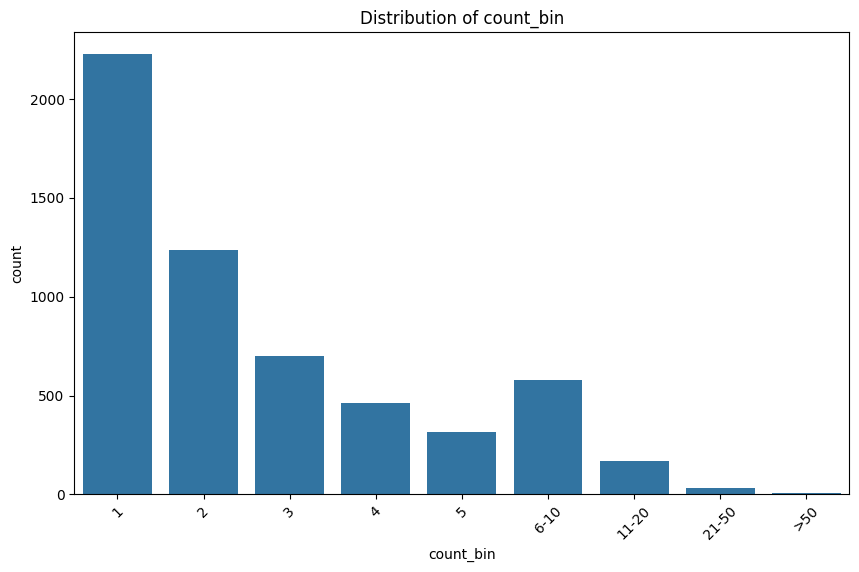

In [ ]:
df_sig_dist = df.copy()
category_counts = df_sig_dist['signature_id'].value_counts()
bins = [0, 1, 2, 3, 4, 5, 10, 20, 50, float('inf')]
labels = ['1', '2', '3', '4', '5', '6-10', '11-20', '21-50', '>50']
category_bins = pd.cut(category_counts, bins=bins, labels=labels, right=True)
category_bins_df = category_bins.reset_index()
category_bins_df.columns = ['signature_id', 'count_bin']
get_dist_by_nb(category_bins_df, ['count_bin'])

The following graph showcases the signature IDs occurring the most in the dataset (top 5)

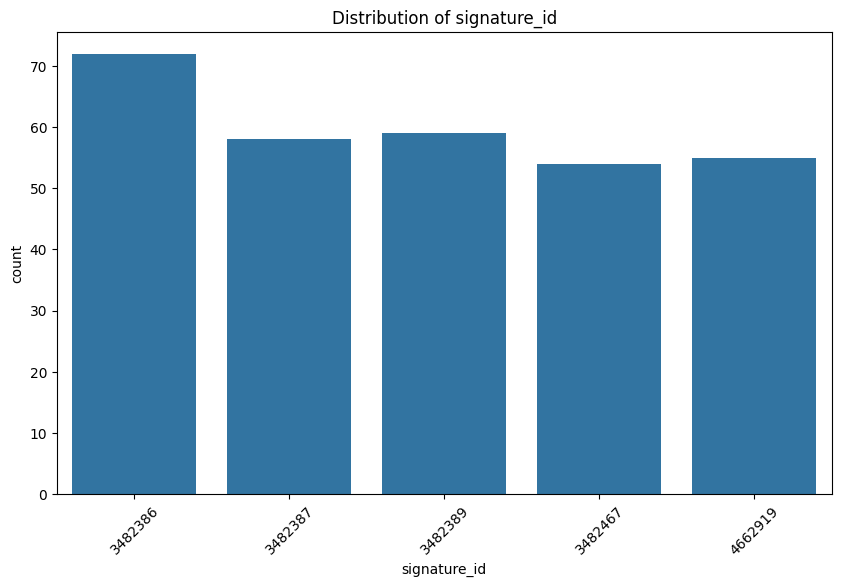

In [ ]:
n = 5
top_n_categories = df['signature_id'].value_counts().nlargest(n).index
filtered_df = df[df['signature_id'].isin(top_n_categories)]
get_dist_by_nb(filtered_df, ['signature_id'])

In [ ]:
most_frequent_signatures = [3482386, 3482387, 3482389, 3482467, 4662919]

The following showcases the top 3 signature IDs associated with true positive alerts

In [ ]:
filtered_df = df[df['alert_status'].isin(["backedout", "fixed", "improvement", "wontfix", "reassigned"])]
sig_counts = filtered_df['signature_id'].value_counts()
top_sig = sig_counts.nlargest(4).index
result_df = filtered_df[filtered_df['signature_id'].isin(top_sig)]
print(result_df["signature_id"].value_counts())
top_tp_sig = [2922314, 4721075, 3807462]

signature_id
2922314    21
4721075    20
3807462    20
3806445    19
Name: count, dtype: int64


The following showcases the top 3 signature IDs associated with false positive alerts

In [ ]:
filtered_df = df[df['alert_status'].isin(["invalid"])]
sig_counts = filtered_df['signature_id'].value_counts()
top_sig = sig_counts.nlargest(4).index
result_df = filtered_df[filtered_df['signature_id'].isin(top_sig)]
print(result_df["signature_id"].value_counts())
top_fp_sig = [2259234, 2680290, 2922314]

signature_id
2259234    26
2680290    19
2922314    10
3756342     9
Name: count, dtype: int64


In [ ]:
def display_sample_2(dataf, sig_id, date_delta=None):
    sample_df = dataf.copy()
    sample_df = sample_df[sample_df["signature_id"] == sig_id]
    if date_delta:
        sample_df = sample_df[sample_df["push_timestamp"] > date_delta]
    sample_df.set_index('push_timestamp', inplace=True)

    #plt.figure(figsize=(12, 8))
    plt.figure(figsize=(20, 10))
    color_mapping = {
        'TP': 'green',
        'FP': 'red',
        'SP': 'grey',
        'TN': 'blue'
    }

    for idx, row in sample_df.iterrows():
        plt.plot(idx, row['value'], marker='o', markersize=8, color=color_mapping.get(row['alert_status']), alpha=0.6)

        # Add vertical line corresponding to each data point of interest
        if row['alert_status'] in ['TP', 'FP', 'SP']:
            plt.axvline(x=idx, color=color_mapping.get(row['alert_status']), linestyle='--', alpha=0.6)

    plt.title('Time Series Plot')
    plt.xlabel('Date')
    plt.ylabel(f'Test measurement values associated with signature ID {sig_id}')
    #plt.grid(True)
    plt.grid(axis='y')
    plt.xlim(sample_df.index.min(), sample_df.index.max())
    y_min = 0
    y_max = sample_df['value'].max() * 2
    plt.ylim(bottom=y_min, top=y_max)
    '''
    plt.ylim(bottom=0)
    xticks = sample_df.index[::10]
    plt.xticks(xticks, rotation=45)'''
    start_date = sample_df.index.min()
    end_date = sample_df.index.max()
    weekly_ticks = pd.date_range(start=start_date, end=end_date, freq='W-MON')
    plt.xticks(weekly_ticks, rotation=45)
    plt.show()
'''
date_x_days_ago = datetime(2024, 5, 15) - timedelta(days=365)
print(4768977)
display_sample_2(df_final, 4768977, date_x_days_ago)

print(4768979)
display_sample_2(df_final, 4768979, date_x_days_ago)

print(4768980)
display_sample_2(df_final, 4768980, date_x_days_ago)

print(4769032)
display_sample_2(df_final, 4769032, date_x_days_ago)'''

'\ndate_x_days_ago = datetime(2024, 5, 15) - timedelta(days=365)\nprint(4768977)\ndisplay_sample_2(df_final, 4768977, date_x_days_ago)\n\nprint(4768979)\ndisplay_sample_2(df_final, 4768979, date_x_days_ago)\n\nprint(4768980)\ndisplay_sample_2(df_final, 4768980, date_x_days_ago)\n\nprint(4769032)\ndisplay_sample_2(df_final, 4769032, date_x_days_ago)'

In [ ]:
def display_sample(dataf, sig_id, date_delta=None):
  sample_df = dataf.copy()
  sample_df = sample_df[sample_df["signature_id"] == sig_id]
  display(sample_df.head(5))
  if date_delta:
    sample_df = sample_df[sample_df["push_timestamp"] > date_delta]
    display(sample_df.head(5))
  sample_df.set_index('push_timestamp', inplace=True)
  plt.figure(figsize=(10, 6))
  plt.plot(sample_df.index, sample_df['value'], marker='o', linestyle='-')
  plt.title('Time Series Plot')
  plt.xlabel('Date')
  plt.ylabel('Test measurement values associated with signature ID ' + str(sig_id))
  plt.grid(True)
  plt.show()

In [ ]:
df1 = pd.read_csv(extension + '/autoland4/3482386_timeseries_data.csv')
df2 = pd.read_csv(extension + '/autoland4/3482387_timeseries_data.csv')
df3 = pd.read_csv(extension + '/autoland4/3482389_timeseries_data.csv')
df4 = pd.read_csv(extension + '/autoland4/3482467_timeseries_data.csv')
df5 = pd.read_csv(extension + '/autoland2/4662919_timeseries_data.csv')
df6 = pd.read_csv(extension + '/autoland4/2922314_timeseries_data.csv')
df7 = pd.read_csv(extension + '/autoland2/4721075_timeseries_data.csv')
df8 = pd.read_csv(extension + '/autoland3/3807462_timeseries_data.csv')
df9 = pd.read_csv(extension + '/autoland4/2259234_timeseries_data.csv')
df10 = pd.read_csv(extension + '/autoland4/2680290_timeseries_data.csv')
timeseries_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10], ignore_index=True).drop_duplicates()
timeseries_df['push_timestamp'] = timeseries_df['push_timestamp'].str.replace("'", "", regex=False)
timeseries_df['push_timestamp'] = pd.to_datetime(timeseries_df['push_timestamp'], format='%Y-%m-%d %H:%M:%S')

<ipython-input-393-5d285b9eb824>:6: DtypeWarning: Columns (47,49,78,83) have mixed types. Specify dtype option on import or set low_memory=False.
  df6 = pd.read_csv(extension + '/2922314_timeseries_data.csv')
<ipython-input-393-5d285b9eb824>:9: DtypeWarning: Columns (47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df9 = pd.read_csv(extension + '/2259234_timeseries_data.csv')
<ipython-input-393-5d285b9eb824>:10: DtypeWarning: Columns (47,49,76,83) have mixed types. Specify dtype option on import or set low_memory=False.
  df10 = pd.read_csv(extension + '/2680290_timeseries_data.csv')
<ipython-input-393-5d285b9eb824>:11: DtypeWarning: Columns (47,49,78,83) have mixed types. Specify dtype option on import or set low_memory=False.
  df11 = pd.read_csv(extension + '/2922314_timeseries_data.csv')


In [ ]:
def print_unique_entries_count(dataf, unique_entry, col):
  print("Number of unique signatures associated with the " + str(unique_entry) + " value of column " + col)
  if (str(unique_entry) == "nan"):
    print(len(dataf[dataf[col].isnull()]["signature_id"].unique()))
  else:
    print(len(dataf[dataf[col] == unique_entry]["signature_id"].unique()))

In [ ]:
for measure_unit in timeseries_df["measurement_unit"].unique():
  print_unique_entries_count(timeseries_df, measure_unit, "measurement_unit")

Number of unique signatures associated with the nan value of column measurement_unit
9
Number of unique signatures associated with the bytes value of column measurement_unit
1


In [ ]:
print(list(set(timeseries_df.columns.tolist()) - set(df.columns.tolist())))
print(list(set(df.columns.tolist()) - set(timeseries_df.columns.tolist())))

['test', 'framework_id', 'lower_is_better', 'suite', 'value', 'repository_name', 'entry_id', 'measurement_unit', 'tags', 'application', 'parent_signature', 'machine_platform', 'extra_options', 'revision', 'push_id', 'push_timestamp', 'job_id', 'signature_hash', 'name', 'has_subtests', 'repository_id', 'test_series_signature_framework_id', 'option_collection_hash', 'should_alert']
['alert_revision']


In [ ]:
common_columns = list(set(df.columns).intersection(set(timeseries_df.columns)) - {'revision', 'alert_revision', 'signature_id', 'alert_revision'})
timeseries_df_extended = timeseries_df.drop(columns=common_columns)
df_merged = pd.merge(timeseries_df_extended, df, left_on=['revision', 'signature_id'], right_on=['alert_revision', 'signature_id'], how='left', suffixes=('', ''))
df_merged['alert_status'].fillna('TN', inplace=True)
df_final = df_merged.drop_duplicates()
df_final.drop(columns=['alert_revision'], inplace=True)

In [ ]:
category_mapping = {
    'investigating': 'SP', # 'SP' stands for 'Still Processing'
    'reassigned': 'SP',
    'invalid': 'FP',
    'improvement': 'TP',
    'fixed': 'TP',
    'wontfix': 'FP',
    'untriaged': 'SP',
    'backedout': 'TP'
}
df_final["alert_status"] = df_final["alert_status"].replace(category_mapping)

In [ ]:
category_counts = df_sig_dist['signature_id'].value_counts()
average_count = category_counts.mean()
median_count = category_counts.median()
print(f"Signatures average count: {average_count:.2f}")
print(f"Signatures median count: {median_count:.2f}")

Signatures average count: 3.17
Signatures median count: 2.00


The following represents the distribution of the alert statuses across the selected signatures

In [ ]:
percentage_counts = df_final['alert_status'].value_counts(normalize=True) * 100
print(percentage_counts)

alert_status
TN    98.890997
SP     0.837726
FP     0.241760
TP     0.029517
Name: proportion, dtype: float64


In [ ]:
df_final["alert_status"] = df_final["alert_status"].replace(category_mapping)

In [ ]:
date_one_year_ago = datetime(2024, 5, 15) - timedelta(days=365)
def display_sig_characteristics(sig_id):
  print("characteristics of signature ID " + str(sig_id))
  display_sample_2(df_final, sig_id, date_one_year_ago)
  subject_sig_df = df_final[df_final['signature_id'] == sig_id]
  percentage_counts = subject_sig_df['alert_status'].value_counts(normalize=True) * 100
  print(percentage_counts)

The following visualization is consisted of timeseries plots as well as alert status distribution for most occurring signatures in the alerts during the last year

characteristics of signature ID 3482386


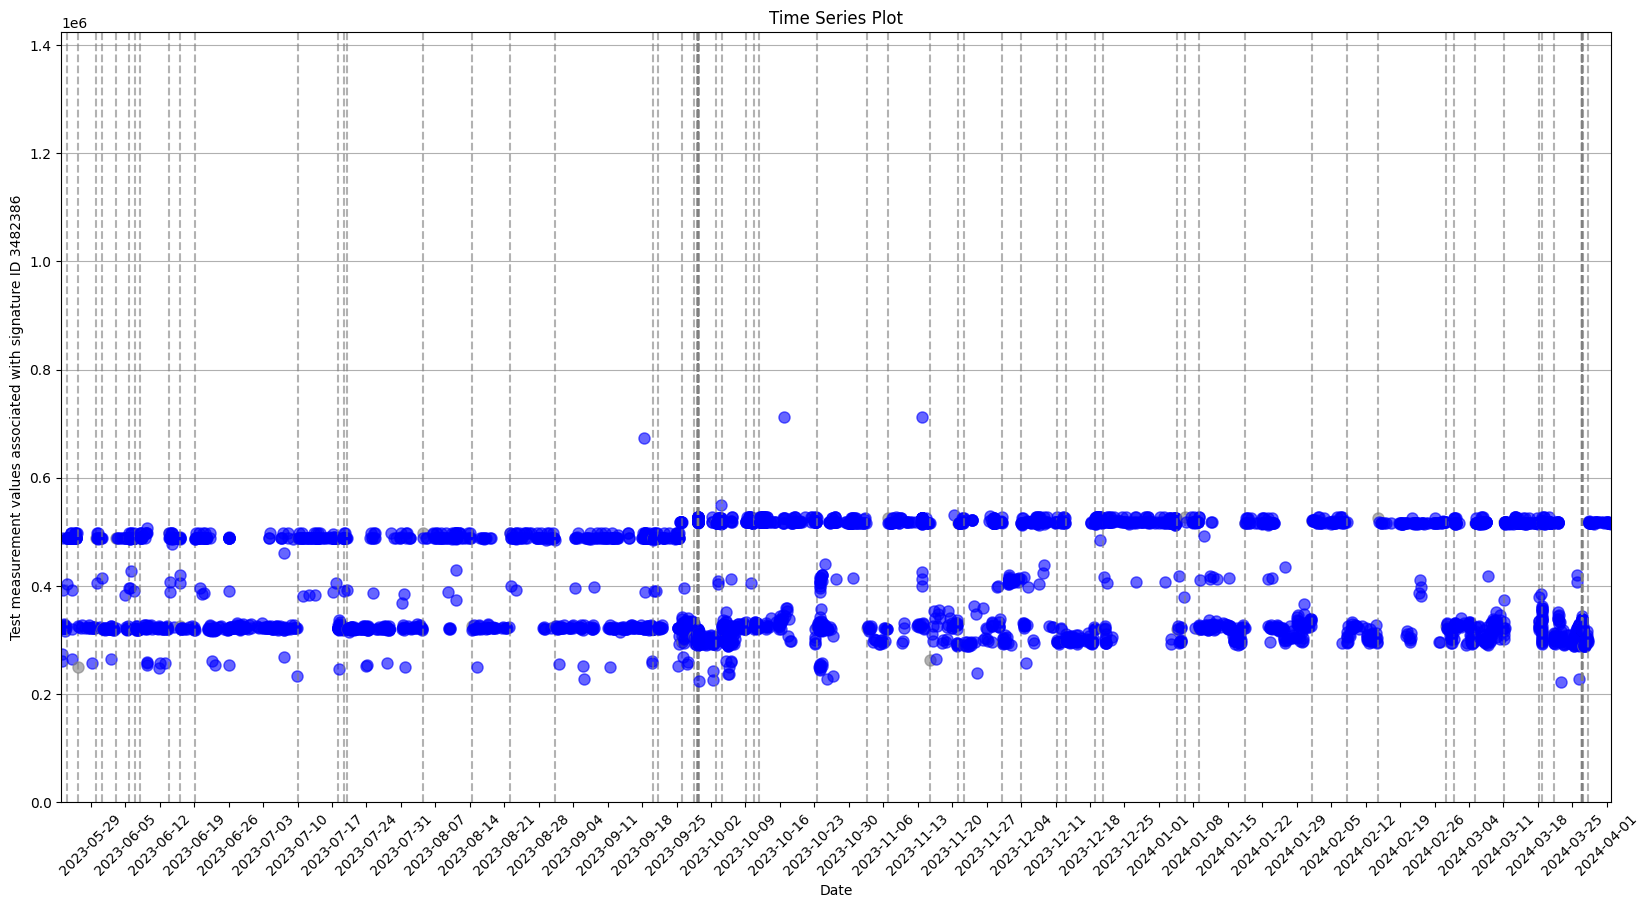

alert_status
TN    97.808808
SP     2.191192
Name: proportion, dtype: float64
characteristics of signature ID 3482387


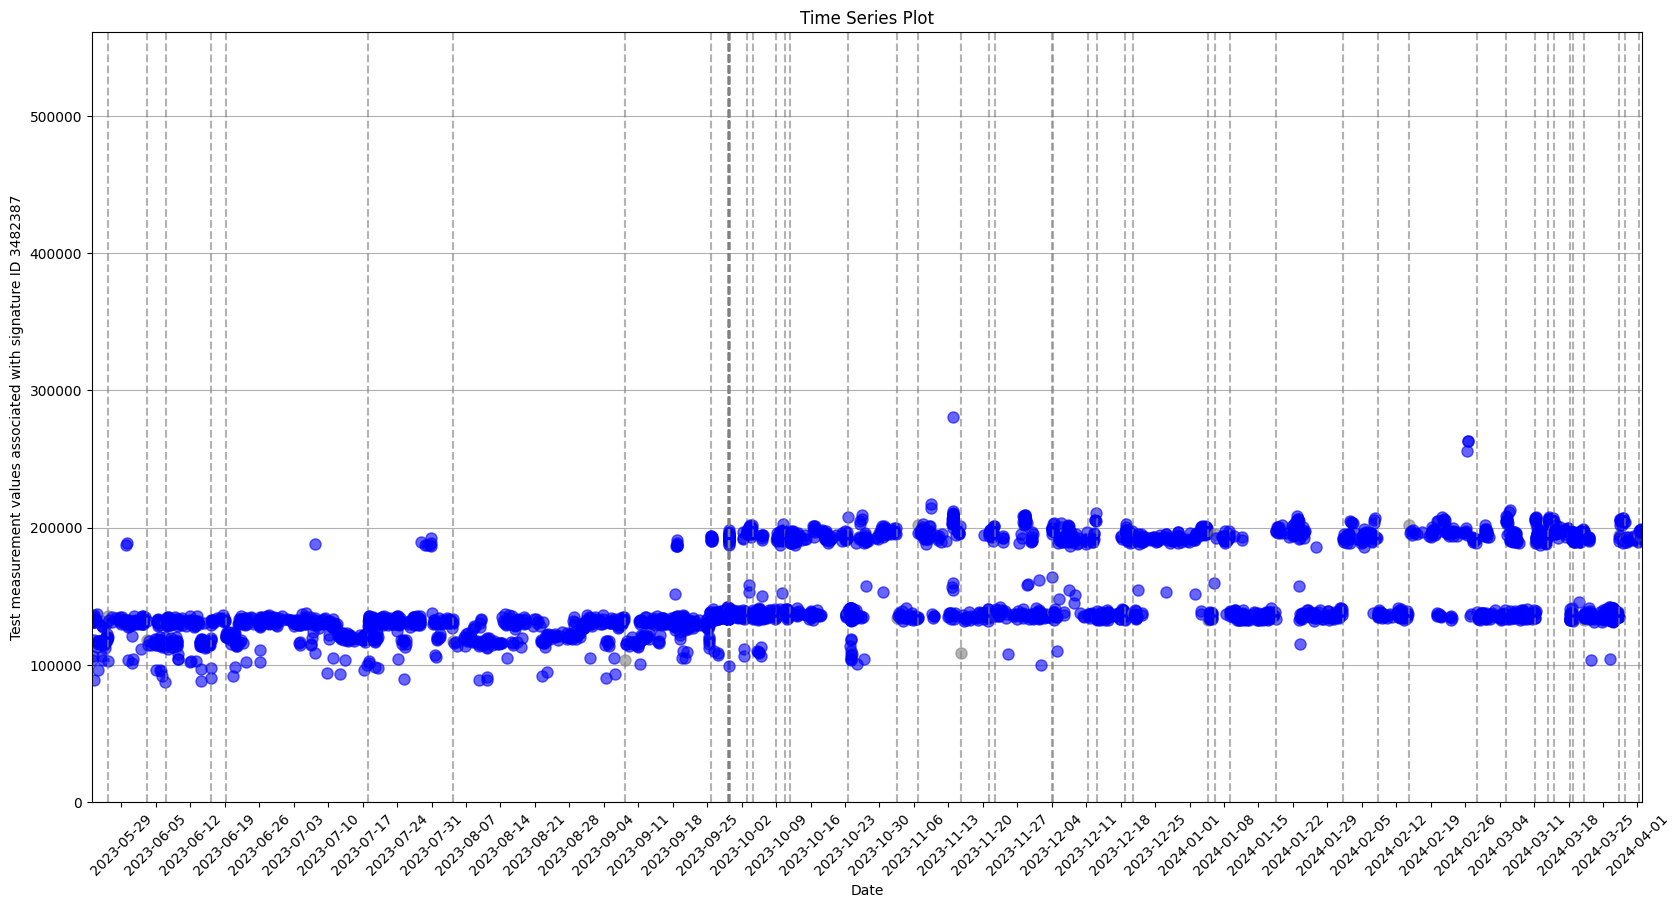

alert_status
TN    98.324382
SP     1.675618
Name: proportion, dtype: float64
characteristics of signature ID 3482389


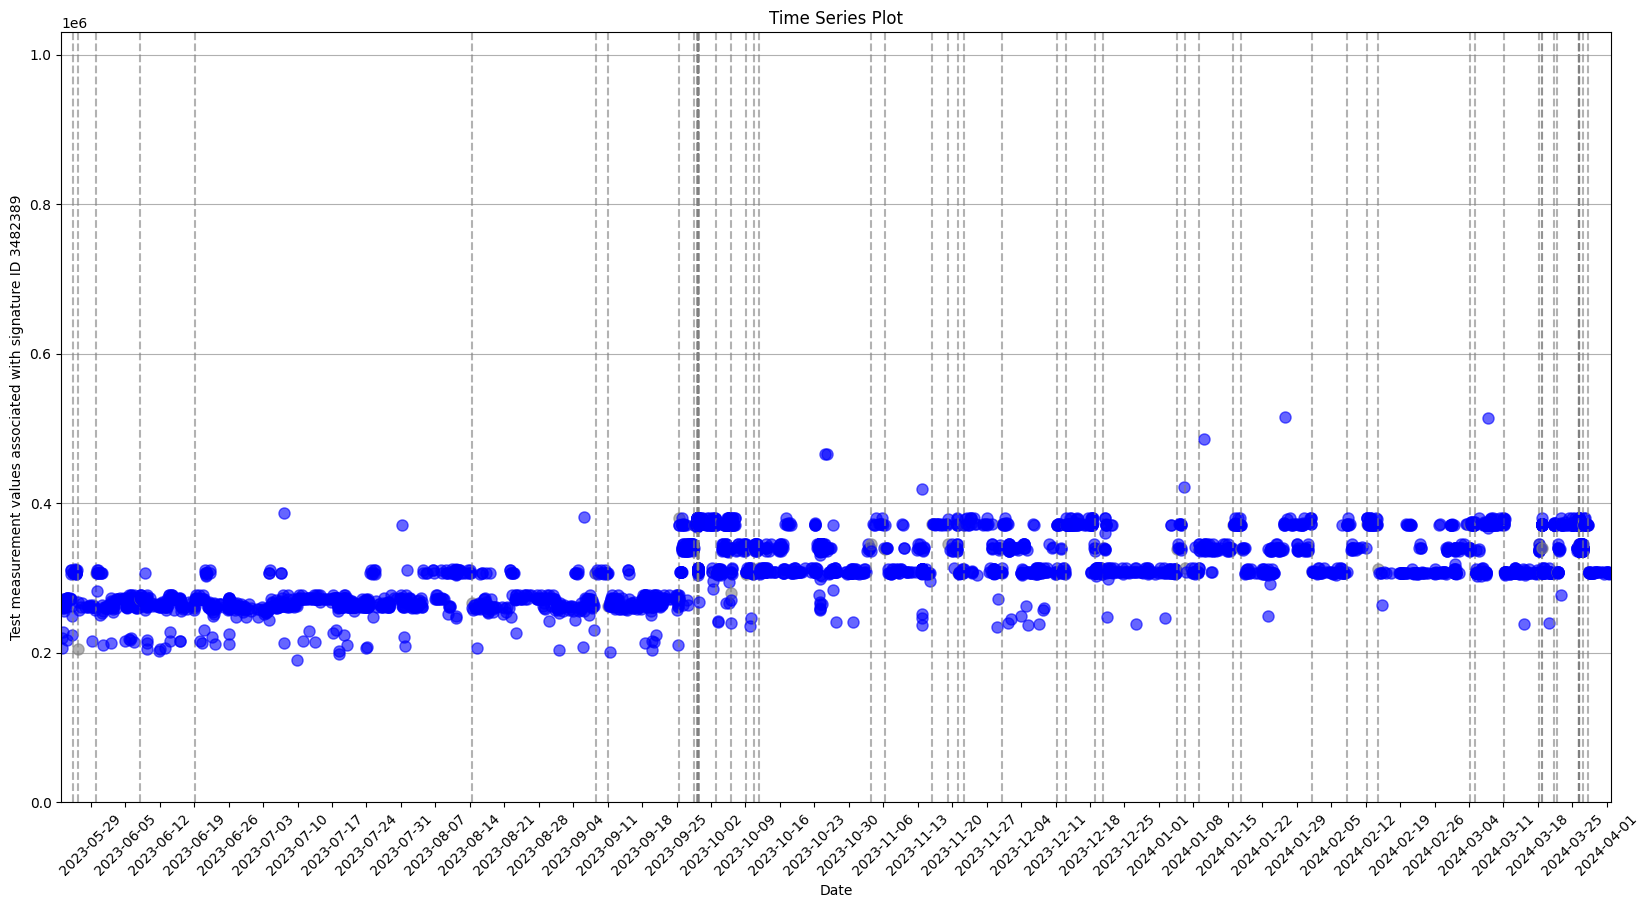

alert_status
TN    98.174006
SP     1.825994
Name: proportion, dtype: float64
characteristics of signature ID 3482467


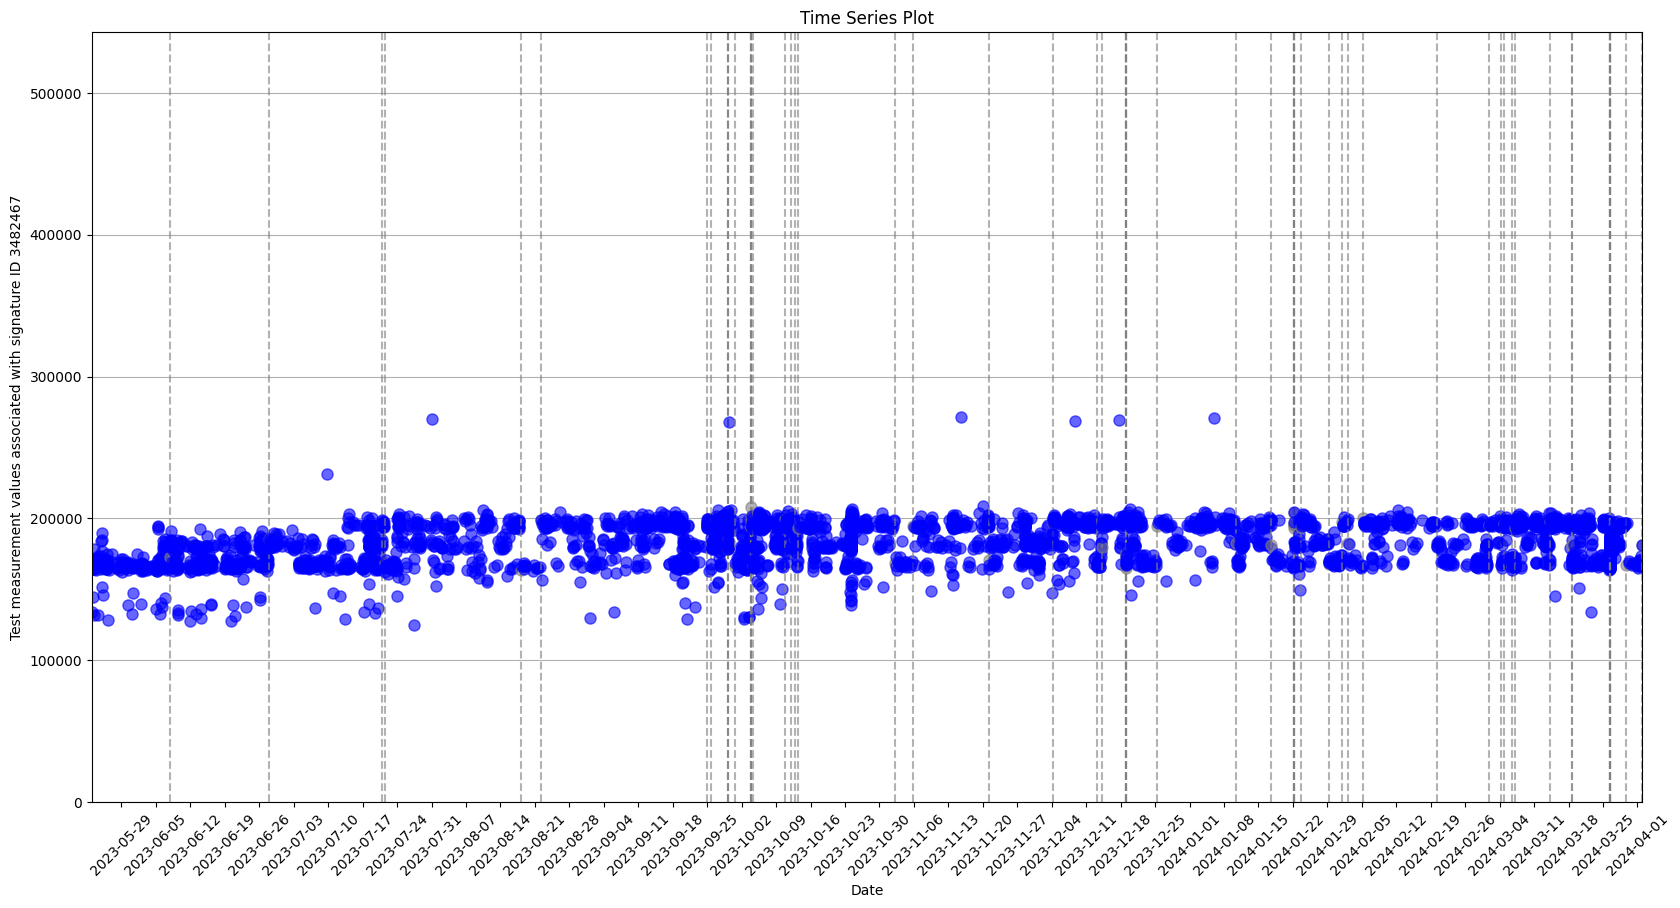

alert_status
TN    98.668099
SP     1.331901
Name: proportion, dtype: float64
characteristics of signature ID 4662919


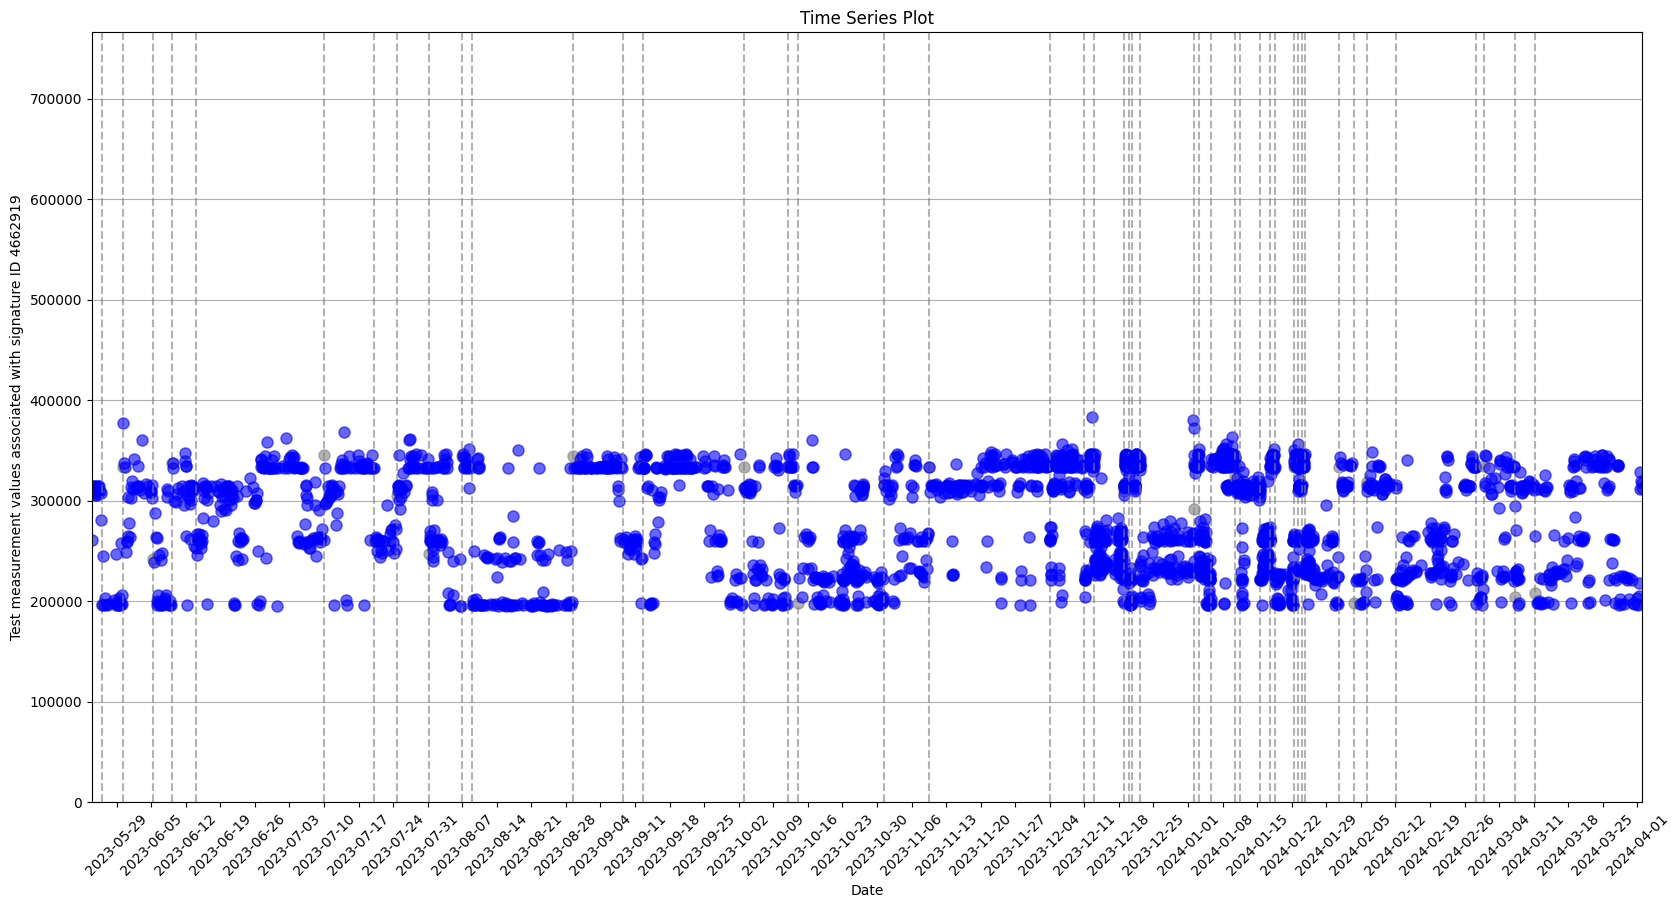

alert_status
TN    98.351254
SP     1.648746
Name: proportion, dtype: float64


In [ ]:
for sig in most_frequent_signatures:
  display_sig_characteristics(sig)

The following visualization is consisted of timeseries plots as well as alert status distribution for signatures associated with true positive alerts the most

characteristics of signature ID 2922314


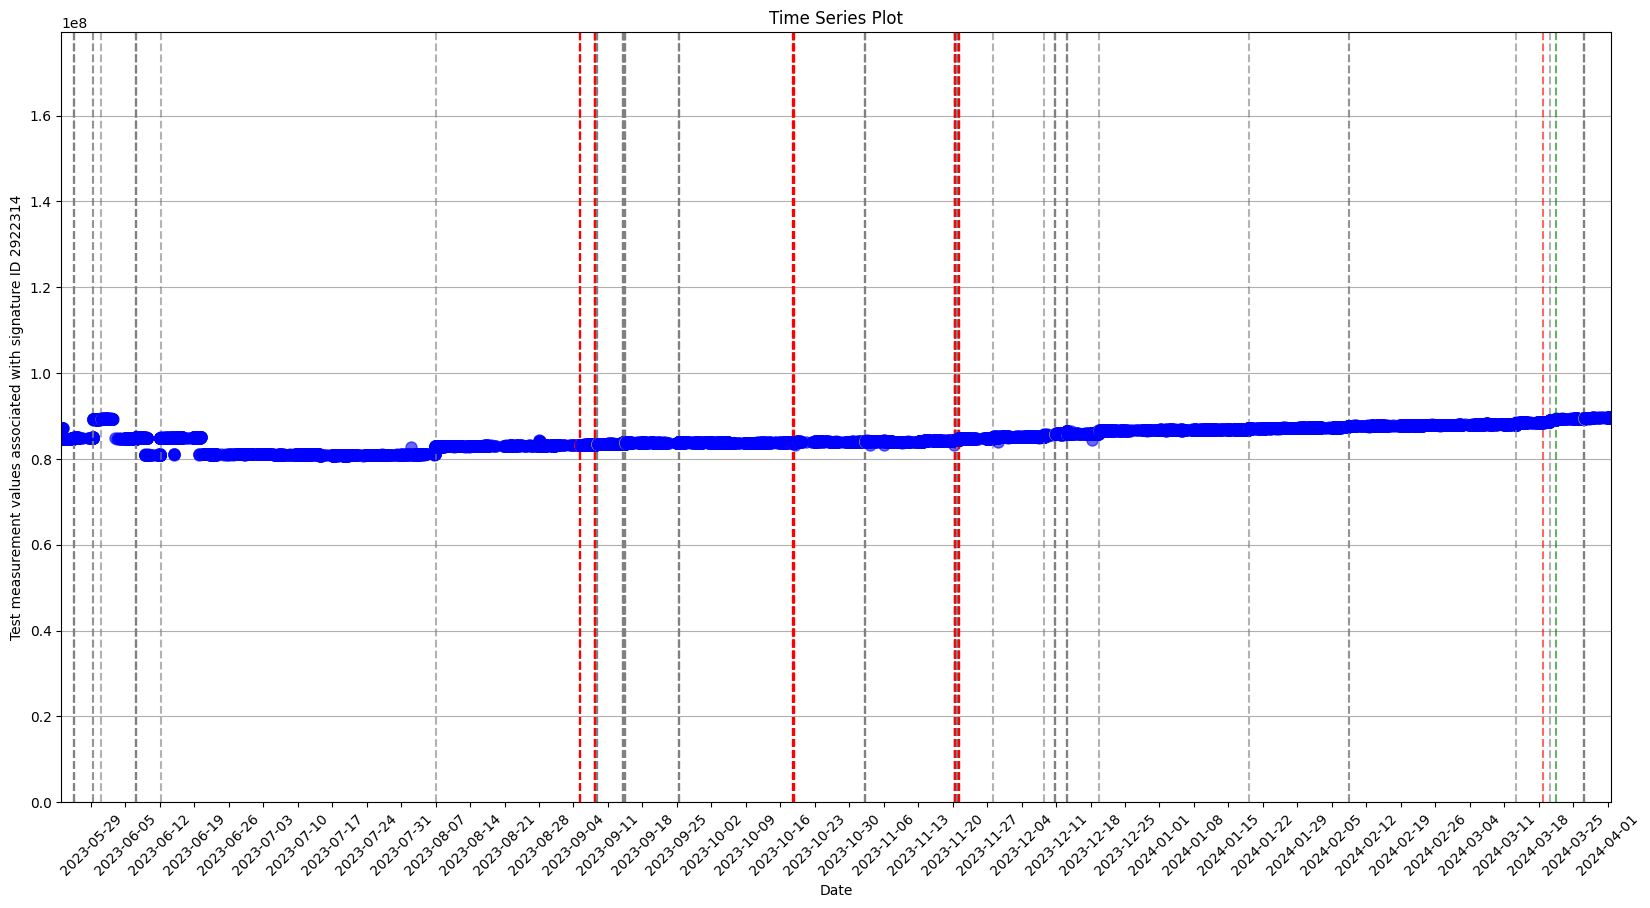

alert_status
TN    98.812207
SP     0.788972
FP     0.390151
TP     0.008670
Name: proportion, dtype: float64
characteristics of signature ID 4721075


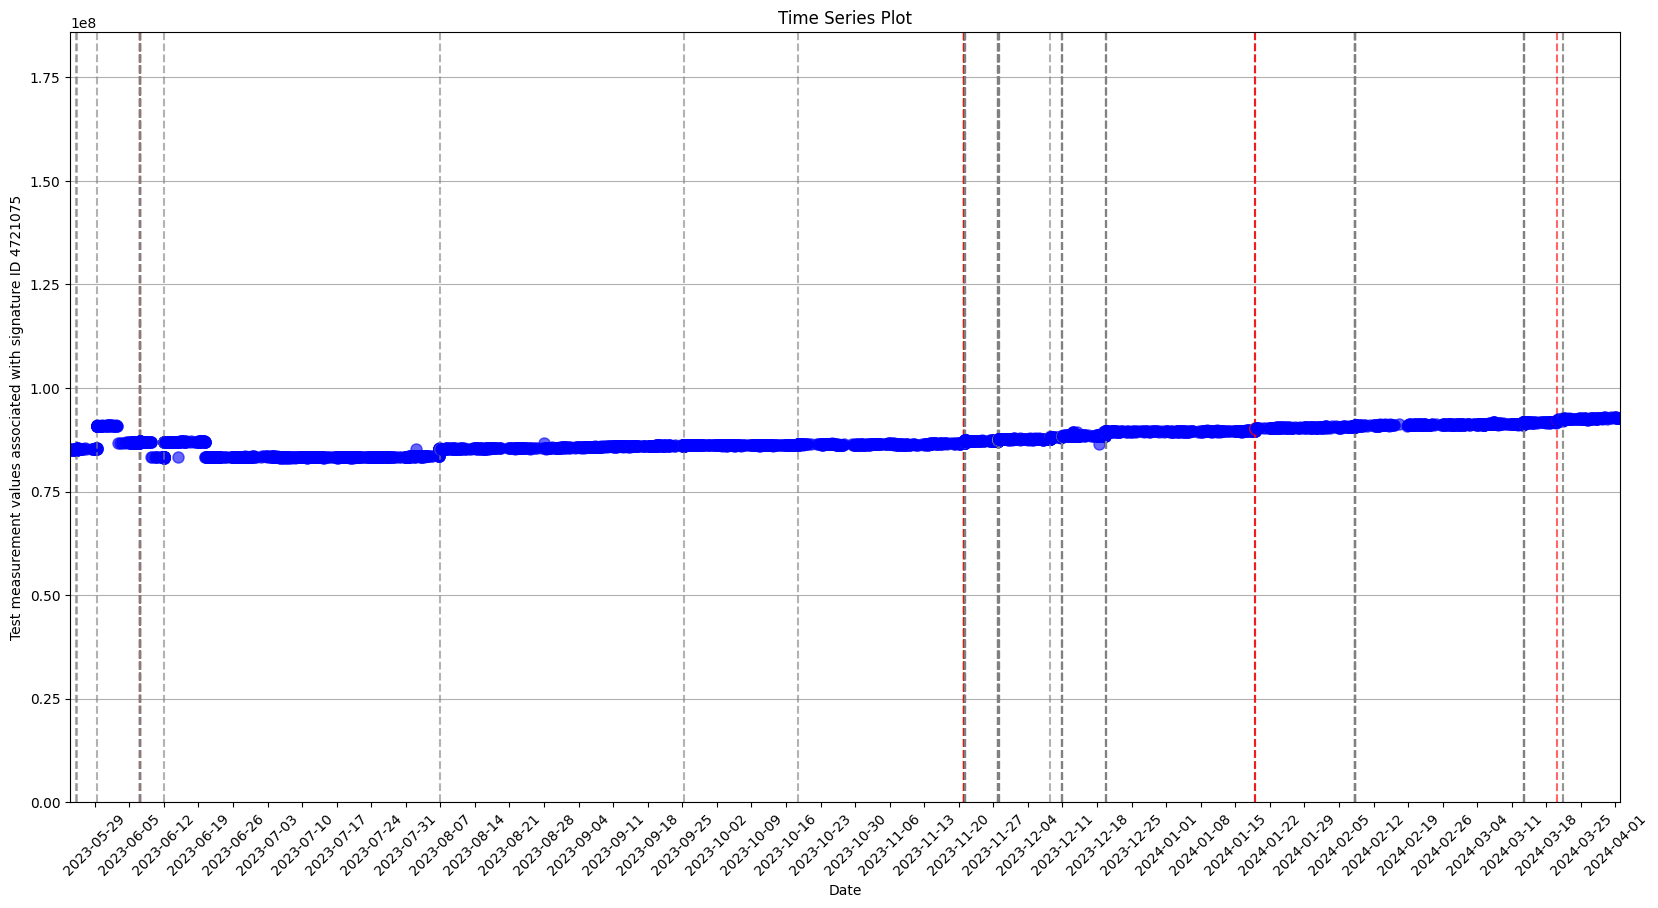

alert_status
TN    97.713568
SP     1.783920
FP     0.351759
TP     0.150754
Name: proportion, dtype: float64
characteristics of signature ID 3807462


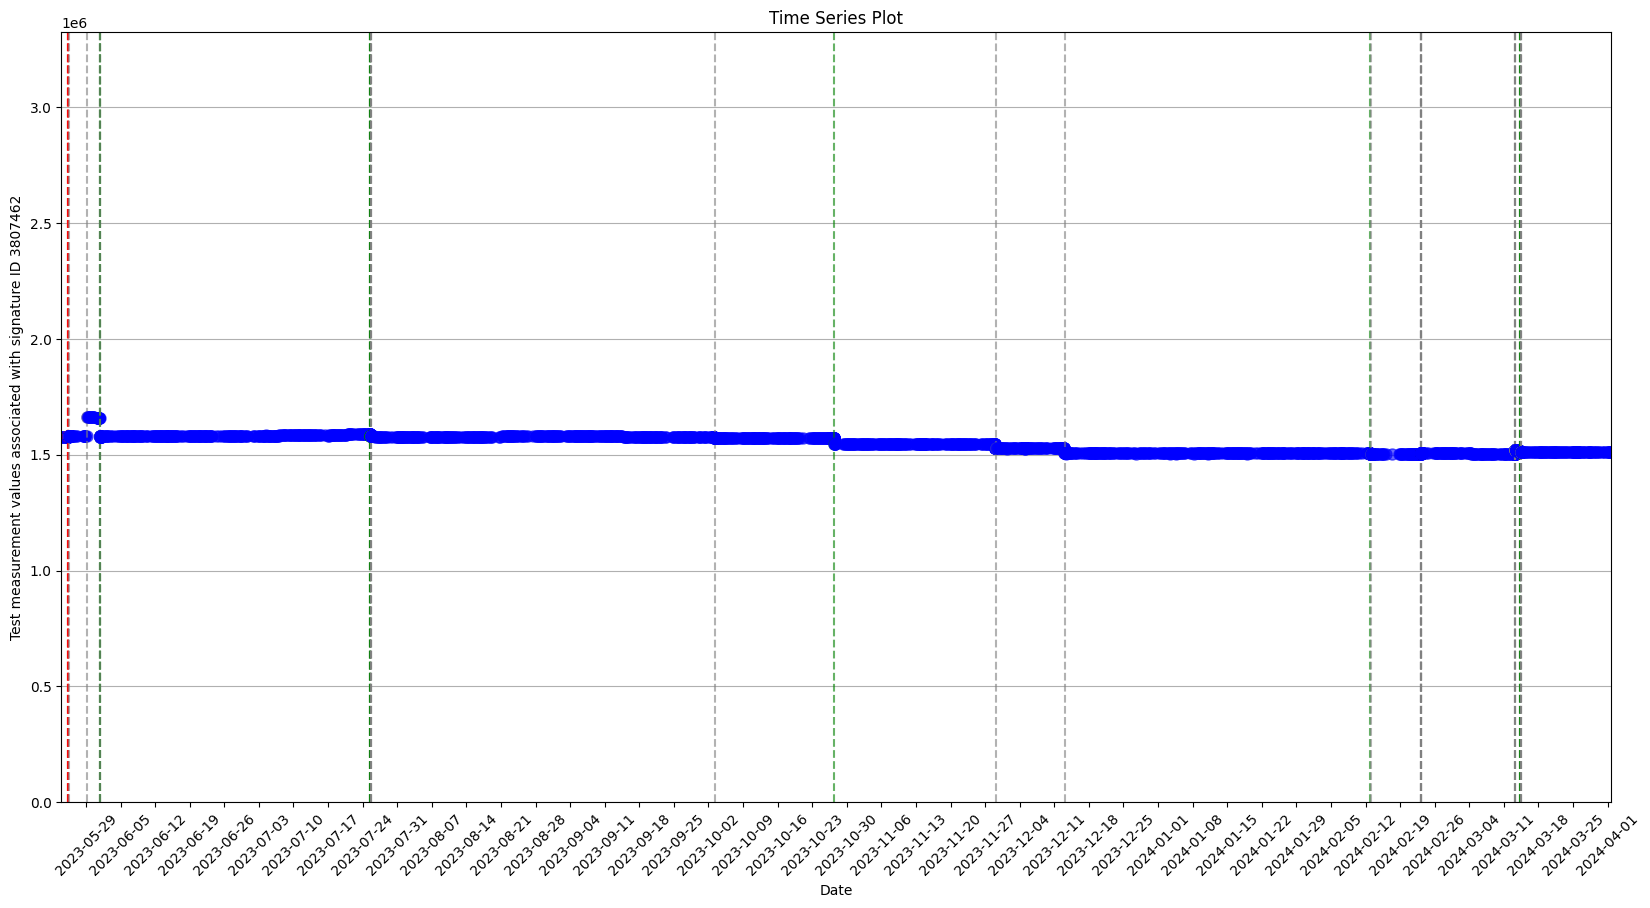

alert_status
TN    98.316913
SP     1.026273
TP     0.492611
FP     0.164204
Name: proportion, dtype: float64


In [ ]:
for sig in top_tp_sig:
  display_sig_characteristics(sig)

The following visualization is consisted of timeseries plots as well as alert status distribution for signatures associated with false positive alerts the most

characteristics of signature ID 2259234
characteristics of signature ID 2259234


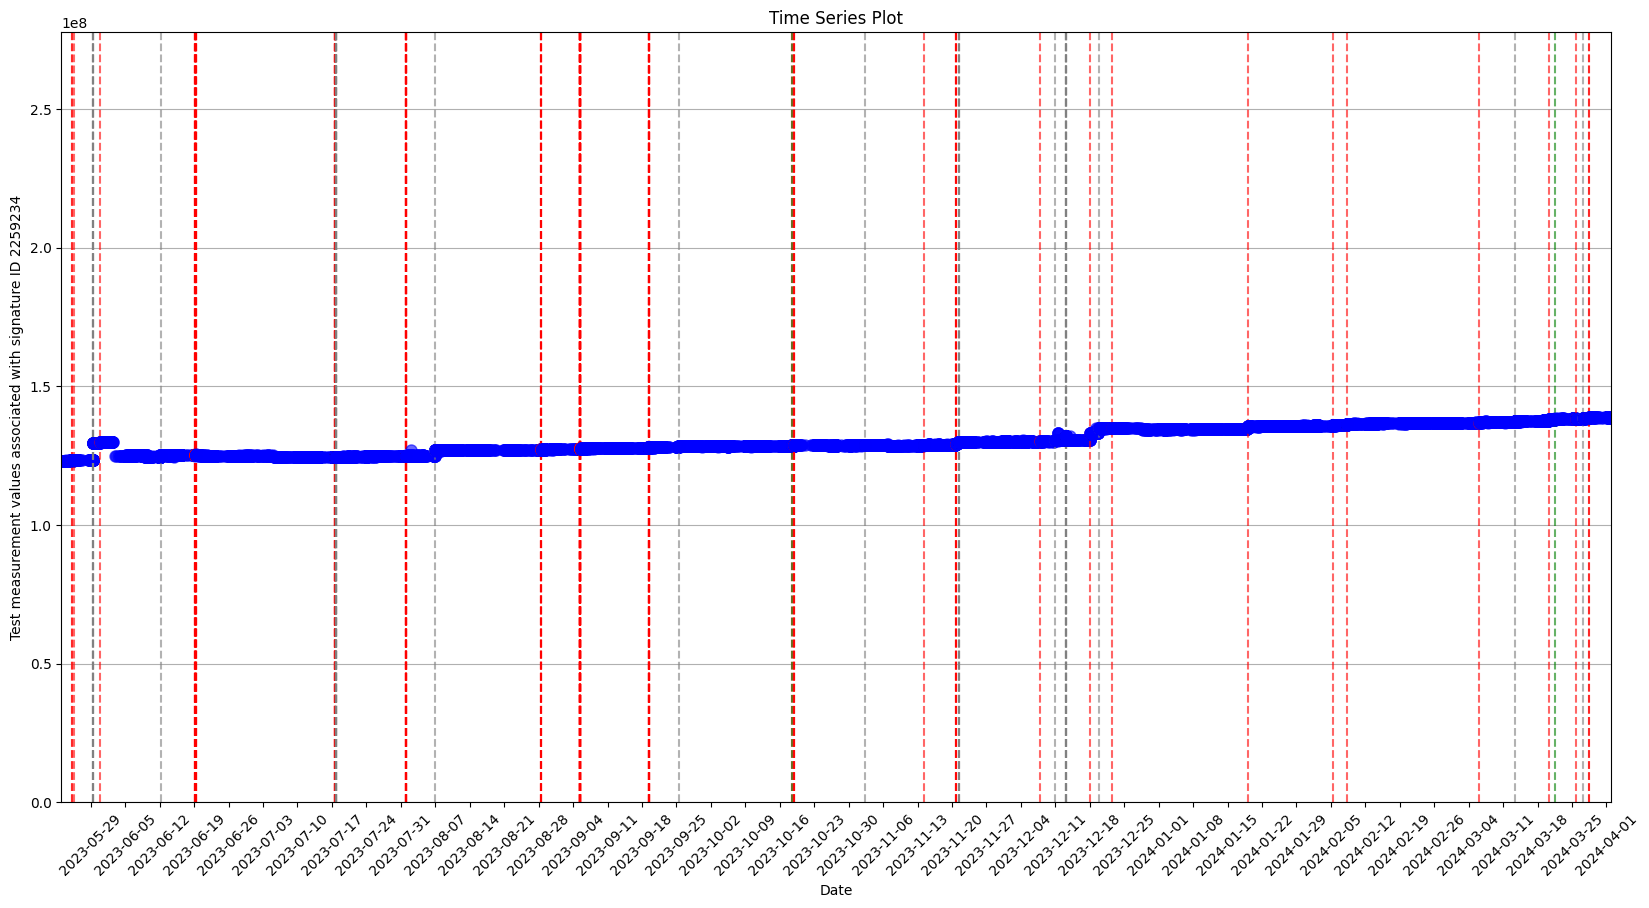

alert_status
TN    98.954593
FP     0.758120
SP     0.271327
TP     0.015960
Name: proportion, dtype: float64
characteristics of signature ID 2680290
characteristics of signature ID 2680290


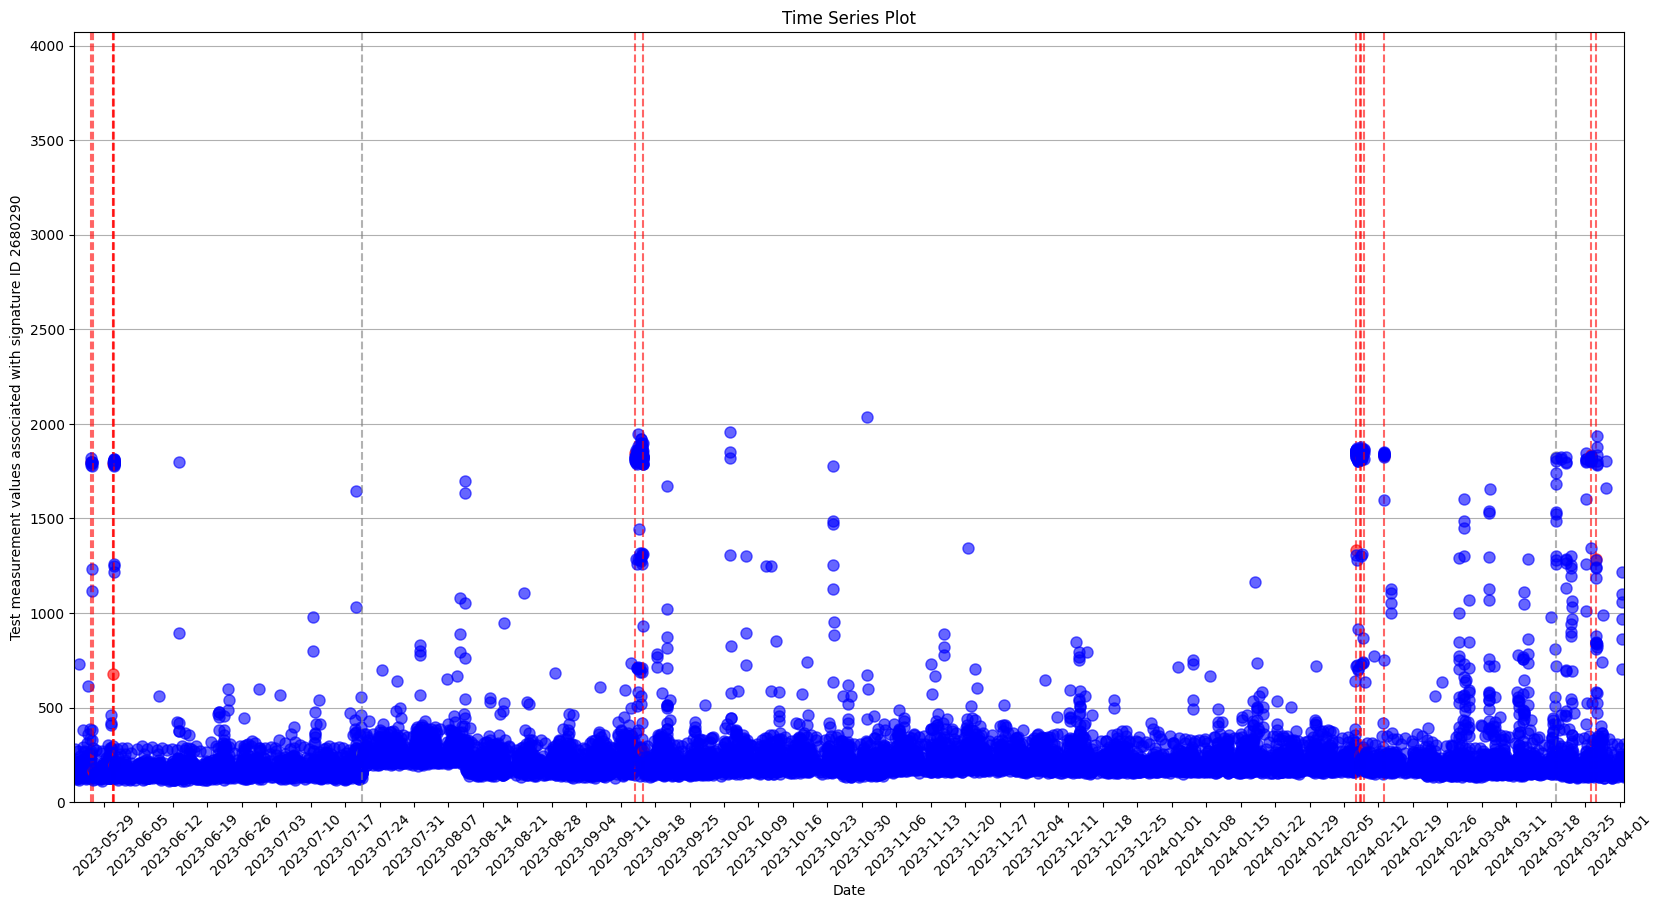

alert_status
TN    99.916900
FP     0.072712
SP     0.010387
Name: proportion, dtype: float64
characteristics of signature ID 2922314
characteristics of signature ID 2922314


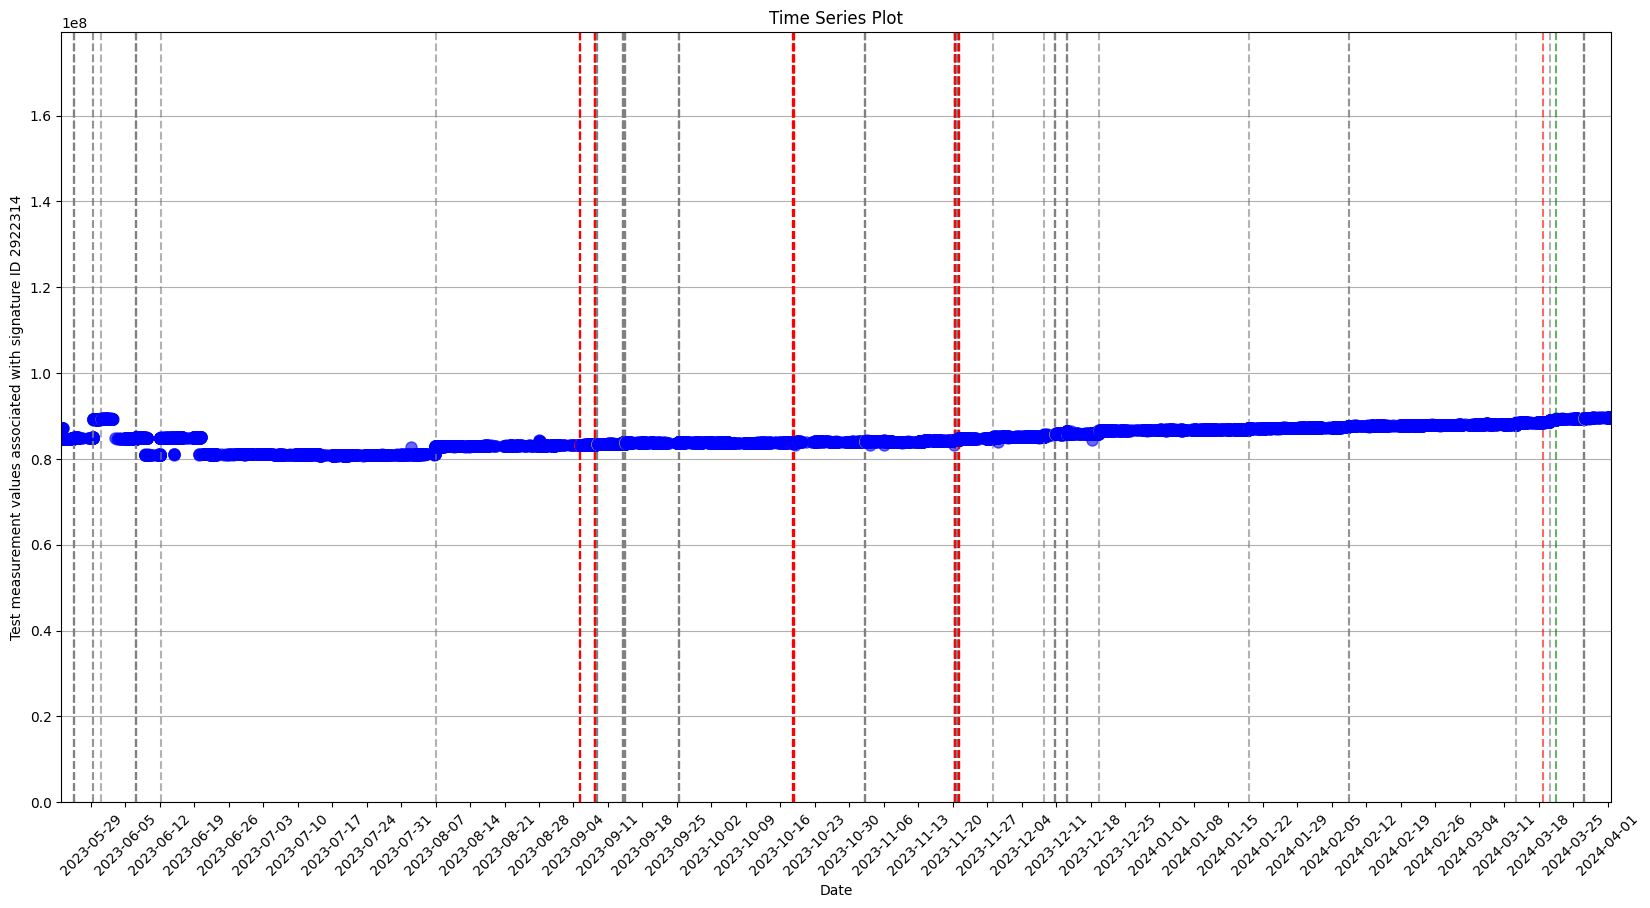

alert_status
TN    98.812207
SP     0.788972
FP     0.390151
TP     0.008670
Name: proportion, dtype: float64


In [ ]:
for sig in top_fp_sig:
  print("characteristics of signature ID " + str(sig))
  display_sig_characteristics(sig)